## **Plot Training Curves**

Before running this notebook make sure tensorboard is running on your localhost using port 6006.
1. Activate your AI environment.
2. Run
`$ tensorboard --logdir <directory that contains tensorboard output files> --port 6006`.

### **Imports**

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests

from csv import reader
from typing import Dict, List

ROOT_DIR = os.path.abspath("../")

### **Functions**

In [7]:
def URLs(tag):
    """
    Generates URLs for fetching scalar data for a given metric (tag).
    
    Args:
        tag (str): The name of the scalar tag to fetch (e.g., 'epoch_mrcnn_bbox_loss').
        
    Returns:
        str: The URL for the scalar data.
    """
    base_url = "http://localhost:6006/data/plugin/scalars/scalars"
    return f"{base_url}?tag={tag}&run=.&format=csv"

def tb_data(metrics: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Fetches scalar data from TensorBoard for specified metrics.
    
    Args:
        metrics (list): List of scalar tags to fetch (e.g., ['epoch_mrcnn_bbox_loss', 'epoch_mrcnn_mask_loss']).
        
    Returns:
        dict: A dictionary where keys are metric names and values are pandas DataFrames.
    """
    
    results = {}
    for metric in metrics:
        url = URLs(metric)
        try:
            r = requests.get(url, allow_redirects=True)
            r.raise_for_status()
            data = r.text
            
            data_csv = reader(data.splitlines())
            data_csv = list(data_csv)
            df = pd.DataFrame(data_csv)
            
            headers = df.iloc[0]
            df = pd.DataFrame(df.values[1:], columns=headers)
            
            df['Step'] = pd.to_numeric(df['Step'])
            df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
            
            results[metric] = df
        except requests.exceptions.RequestException as e:
            print(f"Failed to fetch data for {metric}: {e}")
    
    return results

def plot_loss_from_files(
    run: str,
    layers: str,
    loss_type: str,
    ylim: float = None
) -> None:
    """
    Plots training curves from csv files located in the ROOT_DIR/logs/training/<run> directory.

    Args:
        - run (str): the run ID, the directory name generated during training by Mask-RCNN.
        - layers (str): either 'MRCNN' or 'RPN', used to determine the metric to load.
        - loss_type (str): either 'Mask', 'Class', or 'bbox', used to determine the metric to load.
        - ylim (float): gives the plot a y-limit.
    """
    print(f'{layers} {loss_type} loss')

    loss = pd.read_csv(os.path.join(ROOT_DIR, 'training_curves', run, 'epoch_{}_{}_loss.csv'.format(layers.lower(), loss_type.lower())))
    loss_val = pd.read_csv(os.path.join(ROOT_DIR, 'training_curves', run, 'epoch_val_{}_{}_loss.csv'.format(layers.lower(), loss_type.lower())))

    plt.figure()
    plt.plot(loss['Step'], loss['Value'], label='Train')
    plt.plot(loss_val['Step'], loss_val['Value'], label='Val')

    if ylim:
        plt.ylim(ylim[0], ylim[1])

    plt.xlabel('Epoch')
    plt.ylabel(f'{layers} {loss_type} Loss')
    plt.axvline(30, c='red')
    plt.axvline(60, c='red')
    plt.axvline(90, c='red')
    plt.legend()
    plt.show()

    return None

def plot_loss_from_host(
    data: Dict[str, pd.DataFrame],
    ylim: float = None
) -> None:
    """
    Plots training curves from the 'data' dictionary created by scraping the local tensorboard host
    for data.

    Args:
        - data (dict): dictionary where the keys are the metrics and values are the corresponding dataframes.
        - ylim (float): gives the plots a y-limit.
    """

    for metric in data:
        if 'val' in metric:
            continue

        layers, loss_type = [i for i in metric.split('_') if i not in ['epoch', 'loss']]

        metric_val = metric.replace('epoch', 'epoch_val')

        layers = layers.upper()
        if loss_type != 'bbox':
            loss_type = loss_type.title()

        print(f'{layers} {loss_type} loss')

    

        plt.figure()
        plt.plot(data[metric]['Step'], data[metric]['Value'], label='Train')
        plt.plot(data[metric_val]['Step'], data[metric_val]['Value'], label='Val')

        if ylim:
            plt.ylim(ylim[0], ylim[1])

        plt.xlabel('Epoch')
        plt.ylabel(f'{layers} {loss_type} Loss')
        plt.axvline(30, c='red')
        plt.axvline(60, c='red')
        plt.axvline(90, c='red')
        plt.legend()
        plt.show()
    
    return None


### **Retrieve Data**

In [8]:
metrics = [
    'epoch_mrcnn_mask_loss',
    'epoch_mrcnn_class_loss', 
    'epoch_mrcnn_bbox_loss',
    'epoch_rpn_class_loss',
    'epoch_rpn_bbox_loss',
    'epoch_val_mrcnn_mask_loss',
    'epoch_val_mrcnn_class_loss', 
    'epoch_val_mrcnn_bbox_loss',
    'epoch_val_rpn_class_loss',
    'epoch_val_rpn_bbox_loss',
]

data = tb_data(metrics)

### **Plot**

MRCNN Mask loss


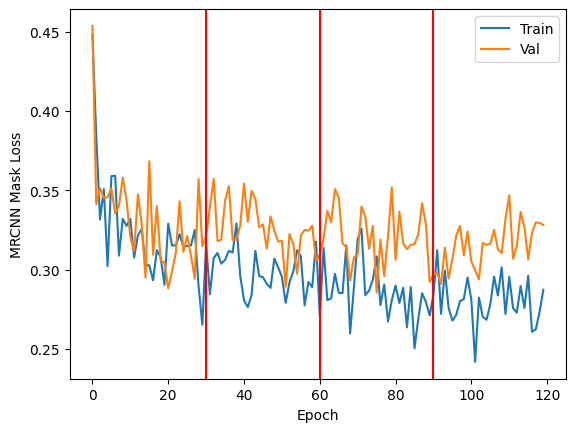

MRCNN Class loss


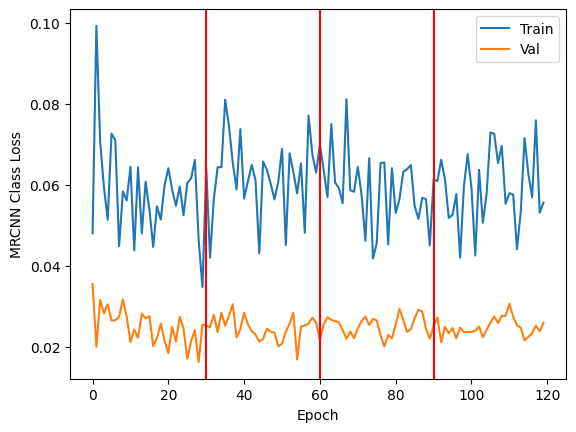

MRCNN bbox loss


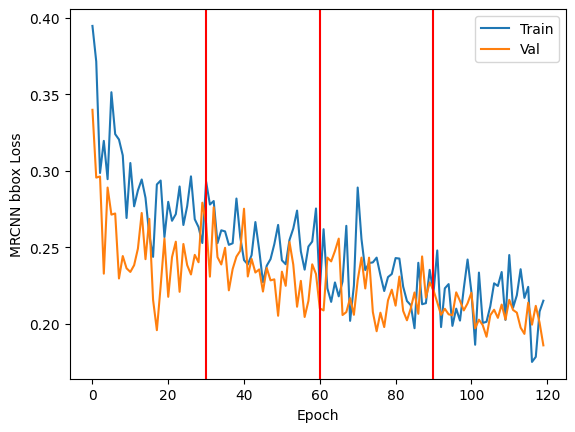

RPN Class loss


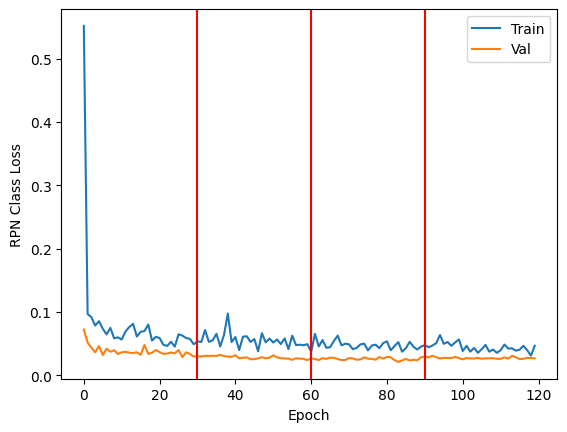

RPN bbox loss


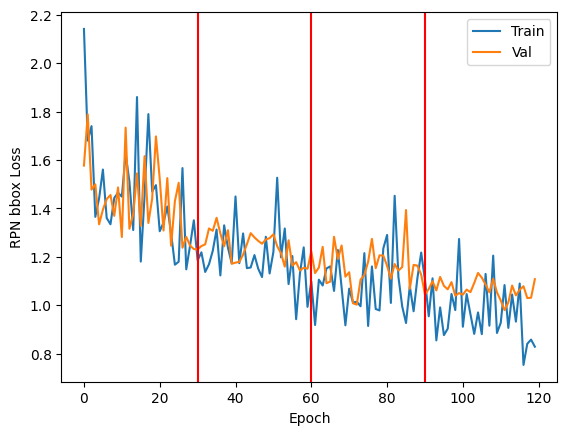

In [9]:
plot_loss_from_host(data)

In [10]:
# run = 'tdm20241121T0658'
# layers = 'MRCNN'
# plot_loss_from_files(run, layers, 'Mask')
# plot_loss_from_files(run, layers, 'Class')
# plot_loss_from_files(run, layers, 'bbox')
# layers = "RPN"
# plot_loss_from_files(run, layers, 'Class')
# plot_loss_from_files(run, layers, 'bbox')